In [1]:
import pylab
import numpy as np
import matplotlib.pyplot as plt
import os
import tempfile
import time
import networkx as nx

from qiskit import Aer
from qiskit.utils import QuantumInstance
from qiskit.tools.visualization import plot_histogram
from qiskit.algorithms import Grover, AmplificationProblem
from qiskit.circuit.library.phase_oracle import PhaseOracle
from qiskit.exceptions import MissingOptionalLibraryError

import warnings
warnings.filterwarnings("ignore")

<frozen importlib._bootstrap>:219: RuntimeWarning: scipy._lib.messagestream.MessageStream size changed, may indicate binary incompatibility. Expected 56 from C header, got 64 from PyObject


In [2]:
'''
works
graph = { "1" : ["2", "3"],
          "2" : ["3", "1"],
          "3" : ["1", "2"],
        }
doesnt work
graph = { "1" : ["2"],
          "2" : ["1", "3"],
          "3" : ["2", "4"],
          "4" : ["3"]
        }

graph = { "1" : ["2", "4"],
          "2" : ["1", "3"],
          "3" : ["2"],
          "4" : ["1"],
        }
'''

graph = { "1" : ["2"],
          "2" : ["1", "3"],
          "3" : ["2"],
        }

So here the quantum oracles are implemented using the SAT problem (Boolean Satisfiability). CNF is Conjuctive Normal Form which is a standardised form of Boolean expresssions where logical ORs are surrounded with logical ANDs.
- means not.
So it sets conditions here to check if two nodes in a graph are connected then they should not have the same colour.

In [3]:
first_clause_set = []
for i in graph:
    for j in graph[i]:
        for c in range(len(graph)):
            first_clause_set.append('-S' + str(i) + 'C' + str(c+1) + ' -S' + str(j) + 'C' + str(c+1) + ' 0')
print(f"There are {len(first_clause_set)} clauses.")
for i in range(len(first_clause_set)):
    print(f" Clause {i+1}: {first_clause_set[i]}")

There are 12 clauses.
 Clause 1: -S1C1 -S2C1 0
 Clause 2: -S1C2 -S2C2 0
 Clause 3: -S1C3 -S2C3 0
 Clause 4: -S2C1 -S1C1 0
 Clause 5: -S2C2 -S1C2 0
 Clause 6: -S2C3 -S1C3 0
 Clause 7: -S2C1 -S3C1 0
 Clause 8: -S2C2 -S3C2 0
 Clause 9: -S2C3 -S3C3 0
 Clause 10: -S3C1 -S2C1 0
 Clause 11: -S3C2 -S2C2 0
 Clause 12: -S3C3 -S2C3 0


The second clause set ensures that each node takes only one colour.

In [4]:
second_clause_set = []
for i in graph:
    second_clause_set.append('-S' + str(i) + 'C1 -S' + str(i) + 'C2 S' + str(i) + 'C3' + ' 0')
    second_clause_set.append('-S' + str(i) + 'C1 S' + str(i) + 'C2 -S' + str(i) + 'C3' + ' 0')
    second_clause_set.append('S' + str(i) + 'C1 -S' + str(i) + 'C2 -S' + str(i) + 'C3' + ' 0')
    second_clause_set.append('S' + str(i) + 'C1 S' + str(i) + 'C2 S' + str(i) + 'C3' + ' 0')
second_clause_set[0]

'-S1C1 -S1C2 S1C3 0'

In [5]:
length = len(first_clause_set) + len(second_clause_set)
first_clause_set = '\n'.join(first_clause_set)
second_clause_set = '\n'.join(second_clause_set)
cnf = first_clause_set + '\n' + second_clause_set
print(f"Length of two clauses of CNF: {length}")
#print(cnf.replace("\n"," "))

Length of two clauses of CNF: 24


In [6]:
all_node_comb = []

for i in graph:
    for j in range(len(graph)):
        all_node_comb.append('S'+ str(i) + 'C' + str(j+1))
#print(all_node_comb)
all_node_comb_dict = {}
for i, j in zip(all_node_comb, range(len(all_node_comb))):
    all_node_comb_dict[i] = str(j + 1)

#print(all_node_comb_dict)
#print(cnf)

for i in all_node_comb_dict:
    cnf = cnf.replace(i, all_node_comb_dict[i])

In [7]:
SAT_input = '''
c example DIMACS-CNF SAT
p cnf '''
# this is just the header for the dimacs cnf file.
SAT_input += str(len(all_node_comb_dict)) + ' ' + str(length) + '\n' + cnf
print(SAT_input)


c example DIMACS-CNF SAT
p cnf 9 24
-1 -4 0
-2 -5 0
-3 -6 0
-4 -1 0
-5 -2 0
-6 -3 0
-4 -7 0
-5 -8 0
-6 -9 0
-7 -4 0
-8 -5 0
-9 -6 0
-1 -2 3 0
-1 2 -3 0
1 -2 -3 0
1 2 3 0
-4 -5 6 0
-4 5 -6 0
4 -5 -6 0
4 5 6 0
-7 -8 9 0
-7 8 -9 0
7 -8 -9 0
7 8 9 0


Create a phase oracle from a string which is in the dimacs format. The DIMAC CNF format is the standard format for specifying SATisfiability instances in CNF.

In [8]:
temp_file = tempfile.NamedTemporaryFile(mode='w+t', delete=False)
#temp_file = open("/tmp/temp","wt")
temp_file.write(SAT_input)
file_name = temp_file.name
temp_file.close()
oracle = None
'''
try:
    oracle = PhaseOracle.from_dimacs_file(file_name)
except MissingOptionalLibraryError as ex:
    print(ex)
finally:
    os.remove(file_name)
'''
try:
    oracle = PhaseOracle.from_dimacs_file(file_name)
except Exception as e:
    print(e)
#oracle = SAT_input
print(oracle)
problem = None
if oracle is not None:
    problem = AmplificationProblem(oracle, is_good_state=oracle.evaluate_bitstring)

                                         
q_0: ─o──o──■──■──o──o──■──■─────────────
      │  │  │  │  │  │  │  │             
q_1: ─o──■──o──o──■──┼──┼──┼──o──o──■──■─
      │  │  │  │  │  │  │  │  │  │  │  │ 
q_2: ─■──┼──┼──┼──o──■──o──o──■──■──o──o─
      │  │  │  │  │  │  │  │  │  │  │  │ 
q_3: ─■──■──o──o──■──■──o──o──o──o──o──o─
      │  │  │  │  │  │  │  │  │  │  │  │ 
q_4: ─o──o──■──■──o──o──o──o──■──■──o──o─
      │  │  │  │  │  │  │  │  │  │  │  │ 
q_5: ─o──o──o──o──o──o──■──■──o──o──■──■─
      │  │  │  │  │  │  │  │  │  │  │  │ 
q_6: ─o──o──■──┼──o──o──■──┼──┼──■──■──┼─
      │  │  │  │  │  │  │  │  │  │  │  │ 
q_7: ─■──┼──o──o──■──┼──┼──■──o──o──┼──■─
         │     │     │  │  │  │     │  │ 
q_8: ────■─────■─────■──o──o──■─────o──o─
                                         


Aer is a high performance simulator for quantum circuits that includes realistic noise models.

In [9]:
begin = time.time()
backend = Aer.get_backend('aer_simulator')
quantum_instance = QuantumInstance(backend, shots=4096)
grover = Grover(quantum_instance=quantum_instance)
result = None
if problem is not None:
    result = grover.amplify(problem)
    end = time.time()
    print(result.assignment)
    print(f"total time taken {end-begin}")

001010001
total time taken 7.483844518661499


In [10]:
def binary_to_decimal(binary):
     
    binary1 = binary
    decimal, i, n = 0, 0, 0
    while(binary != 0):
        dec = binary % 10
        decimal = decimal + dec * pow(2, i)
        binary = binary//10
        i += 1
    #print(decimal)
    return decimal

['001', '010', '001']
['green', 'blue', 'green']


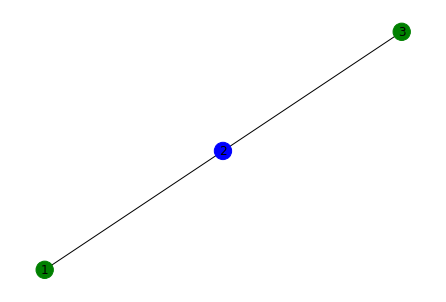

In [11]:
G = nx.Graph(graph)
pos = nx.spring_layout(G)

result_split = [str(result.assignment)[i*3: i*3+3] for i in range(int(len(str(result.assignment))/3))]
print(result_split)
colour = ['red', 'green', 'blue']
colour_map = [None for i in graph]
for i, j in zip(result_split, range(len(result_split))):
    if binary_to_decimal(int(i))%3 == 0:
        colour_map[j] = colour[0]
        continue
    elif binary_to_decimal(int(i))%3 == 1:
        colour_map[j] = colour[1]
        continue
    elif binary_to_decimal(int(i))%3 == 2:
        colour_map[j] = colour[2]
        continue

print(colour_map)

nx.draw(G, pos, node_color=colour_map, with_labels=True)
plt.show()
